# RESEARCH IN PYTHON: Discrete Time Survival Analysis
#### by [J. Nathan Matias](http://natematias.com),  April 4, 2015

*THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.*

## About Discrete Time Survival Analysis
In discrete time survival analysis, we calculate the probability of an event occurring in a particular time period (*hazard probability*) as well as the probability that a given number of cases might have experienced (or not experienced) that event after a certain number of periods (*survival probability*). 

In this example, I follow the approach used by Singer and Willett in [Applied Longitudinal Data Analysis: Modeling Change and Event Occurrence](http://www.ats.ucla.edu/stat/examples/alda/) Chapter 10 on "Fitting Discrete Time Hazard Models," but with an example from Wikipedia.


## Dataset
None of the examples of discrete time survival analysis look at online behaviour, so I have created an example using **Wikipedia data** from the [Wikipedia Participation Challenge](http://blog.wikimedia.org/2011/06/28/data-competition-announcing-the-wikipedia-participation-challenge/) posted to Kaggle in 2011. The ([Kaggle challenge](https://www.kaggle.com/c/wikichallenge/)). To make this clearer, and to reduce the overhead, I fit a modified version of the *validation* dataset of edits from 21105 users, rather than the much larger training dataset.

This page *does not* offer a proposed solution to the challenge. Contributors submitted 1029 entries, using a large variety of methods. [The top contributors are listed here](http://blog.wikimedia.org/2011/10/26/announcing-the-wikichallenge-winners/), with [further discussion here](https://www.kaggle.com/forums/f/15/kaggle-forum/t/980/wikipedia-participation-challenge-an-unfortunate-ending/6288). Rather, this example sets out to use the Wikipedia data to illustrate a particular approach to linear regression.

## Libraries

This example makes extensive use of the [Lifelines](http://lifelines.readthedocs.org/en/latest/) library, which offers features that go well beyond the methods in Singer & Willet's introductory chapter on discrete time hazard models.

# Research Question: Is there a Relationship between Reversion Rate and the Probability of Ceasing Contribution to Wikipedia?

In this analysis, we are testing a question-motivated hypothesis rather than attempting to accurately predict/model unobserved users (which was the focus of the Wikipedia challenge). Our hypothesis is that **there is a relationship between reversion rate and the probability of ceasing contributions, on average in the population of Wikipedians** such that a higher rate of edit reversion is associated with a higher probability of ceasing contributions. This can also be expressed in terms of survival by implication: Wikipedians whose contributions are reverted at lower rates have a higher probability of continue to make contributions, on average in the population.

Note that this is not a causal analysis-- if we find support for this hypothesis, we cannot claim that reversions *cause* people to leave Wikipedia. Within the methods in this document, it's also plausible that people who make often-reverted edits aren't very interested in Wikipedia or very good writers, and leave because they lost interest. 

To establish causality, we would have to use other methods, such the methods used by Aaron Halfaker, Aniket Kittur, and John Riedl in their 2011 WikiSym paper [Don't Bite the Newbies: How reverts affect the quantity and quality of Wikipedia work](http://www-users.cs.umn.edu/~halfak/publications/Don't_Bite_the_Newbies/), who used a matched comparison method to test the causal relationship between reverts and contributions to Wikipedia.

In [421]:
%matplotlib inline
import codecs
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from scipy import stats as ss
import csv

from collections import Counter
from collections import defaultdict

import seaborn as sns
from scipy import stats
from dateutil import *
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re
import sys

## FILES TO IMPORT FOR LIFE TABLE ANALYSIS
import lifelines
kmf = lifelines.KaplanMeierFitter()
#naf = lifelines.NelsonAalenFitter()

## Load Dataset of Wikipedia Edits by User from the Kaggle Data

In [422]:
import csv
cols = None

user_edits = defaultdict(list)

# Data was provided under the Creative Commons Attribution-Share-Alike 3.0 license
# https://creativecommons.org/licenses/by-sa/3.0/us/
with open("wikipedia-validation.tsv") as tsv:
    for line in csv.reader(tsv, dialect="excel-tab"):
        row = {}
        if(cols is None):
            cols = line
        else:
            for i in range(len(cols)):
                row[cols[i]] = line[i]
            user_edits[row['user_id']].append(row)        

## Generate Life Tables
Here, we generate a table of the earliest month, last month, and number of months active. We also identify whether the account is "censored" -- e.g. active in the last recorded month. Censoring allows us to account for the fact our data collection ended before finding out when these accounts ceased contributing to Wikipedia (many of them are likely still editing to this day).

In [423]:
def diff_month(d1, d2):
    return (d1.year - d2.year)*12 + d1.month - d2.month

# This method generates a row with details we're interested in
# that then becomes the dataframe for life table analysis
def generate_user_row(u):
    r = {"user_id":u[0]['user_id'],
           "edits":len(u),
           "reversions":len([x for x in u if int(x['reverted'])==1]),
           "namespaces":len(set([x['namespace'] for x in u]))}
    sorted_dates = sorted([x['timestamp'] for x in u])
    r['earliest_edit'] = parser.parse(sorted_dates[0])
    #r['earliest_month'] = int(r['earliest_edit'].strftime("%Y%m"))
    r['last_edit'] = parser.parse(sorted_dates[-1])
    r['last_month'] = int(r['last_edit'].strftime("%Y%m"))
    r['edit_days'] =  (r['last_edit'] - r['earliest_edit']).days
    r['edit_months'] = diff_month(r['last_edit'], r['earliest_edit'])
    return r

def flip(val):
    flip={0:1,1:0,None:None}
    return flip[val]


user_rows = []
for user in user_edits.keys():
    # remove an outlier for pedagogical purposes
    if(user_edits[user][0]['user_id']=='526223'):
        continue
    else:
        user_rows.append(generate_user_row(user_edits[user]))

udf = pd.DataFrame(user_rows)

# GENERATE A LIST OF CENSORED RECORDS
# WHO CONTRIBUTED IN THE FINAL RECORDED MONTH
maxmonth = udf.last_month.max()
def censored(last_month):
    if last_month == maxmonth:
        return 1
    return 0

udf['censored'] = udf.last_month.map(censored)
udf['dropout'] = udf.censored.map(flip)

# Kaplan Meier Survival Curve based on Days Since First Edit

Here we use the lifelines library to plot the Kaplan Meier Survival Curve from the life tables. Lifelines has a great number of features that are left out of this example, along with especially well-written, clear, helpful documentation. [The Lifelines documentation reads more like a tutorial](http://lifelines.readthedocs.org); I highly recommend it.

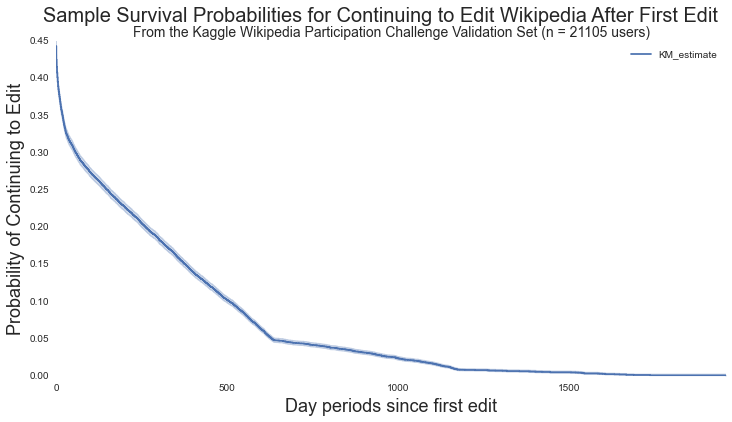

In [424]:
f, ax = plt.subplots(1,1, figsize=(12,6))

# fit the 
kmf.fit(udf.edit_days,udf.dropout)
kmf.plot(ax=ax)

plt.suptitle("Sample Survival Probabilities for Continuing to Edit Wikipedia After First Edit",
          fontsize="20")
plt.title("From the Kaggle Wikipedia Participation Challenge Validation Set (n = %(n)d users)" %{"n":len(user_rows)},
         fontsize="14")
ax.set_xlabel("Day periods since first edit", fontsize="18")
ax.set_ylabel("Probability of Continuing to Edit",fontsize="18")
plt.show()

# Kaplan Meier Survival Curve on Months Since first Edit

To make our example clearer, and to use the Singer & Willett method of regression on individual periods as a first attempt at fit, we focus on month periods in this analysis.

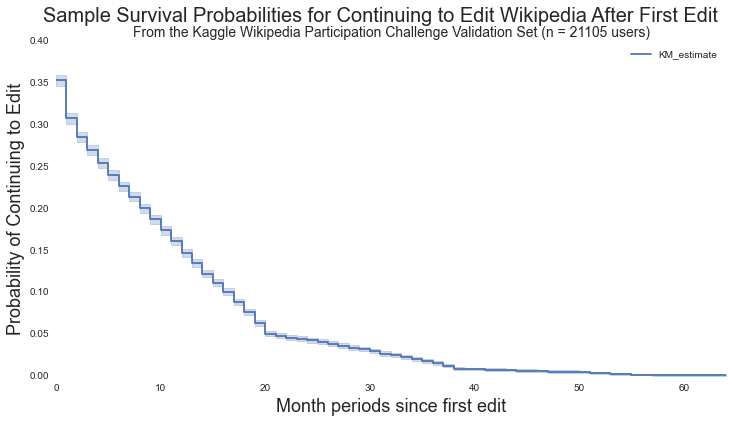

In [425]:
f, ax = plt.subplots(1,1, figsize=(12,6))

# fit the 
kmf.fit(udf.edit_months,udf.dropout)
kmf.plot(ax=ax)

plt.suptitle("Sample Survival Probabilities for Continuing to Edit Wikipedia After First Edit",
          fontsize="20")
plt.title("From the Kaggle Wikipedia Participation Challenge Validation Set (n = %(n)d users)" %{"n":len(user_rows)},
         fontsize="14")
ax.set_xlabel("Month periods since first edit", fontsize="18")
ax.set_ylabel("Probability of Continuing to Edit",fontsize="18")
plt.show()

# Generate and Describe Covariates

In this section, I generate a variety of possible covariates for edit count and reversion count. Since the purpose of this analysis is to demonstrate a technique, I ultimately settle on ''reversion rate'', which is the frequency of reversions against total number of edits for the entire observed period.

If we were aiming to win the Kaggle competition, we would want to develop a better method for modeling people with a reversion rate of 0 compared to people with nonzero reversion rates, as illustrated in the historgrams. This is discussed in [a blog post by Adam Hyland on R Bloggers](http://www.r-bloggers.com/wikipedia-for-kaggle-participants/).

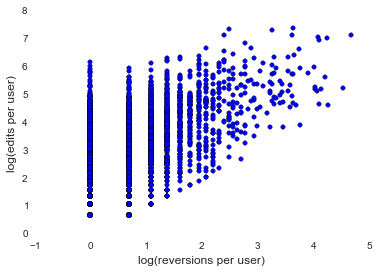

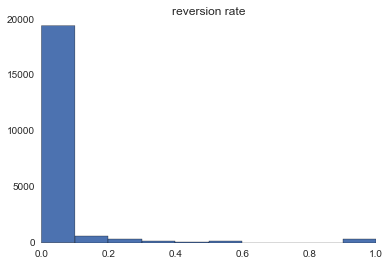

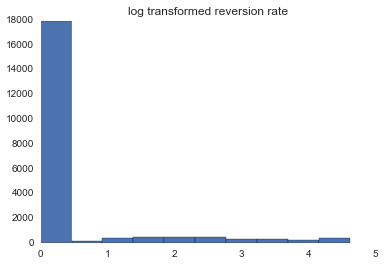

In [426]:
#GENERATE COVARIATES
def rrate(row):
    return float(row.reversions)/float(row.edits)

udf['log_reversions'] = udf.reversions.map(math.log1p)
udf['log_edits'] = udf.edits.map(math.log1p)
udf['reversion_rate'] = udf.apply(rrate, axis=1)
udf['log_reversion_rate'] = udf.reversion_rate.map(lambda x: math.log1p(x*100.))
plt.xlabel("log(reversions per user)", fontsize="12")
plt.ylabel("log(edits per user)", fontsize="12")
plt.scatter(udf.log_reversions, udf.log_edits)
plt.show()
plt.hist(udf.reversion_rate)
plt.title("reversion rate")
plt.show()
plt.hist(udf.log_reversion_rate)
plt.title("log transformed reversion rate")
plt.show()

# Generating a Person Period Dataset on Months

To do regression analysis on a life table, we convert it to a person-period dataset, where each row represents a month-long period between the month period of first activity and the month of the last edit made by that person.

This approach doesn't care at all about the activity of that user in that period, only whether they had not yet left Wikipedia for good, as defined by whether they made an edit in the last month of the period analyzed. This is a HUGE assumption and is probably wrong for a lot of Wikipedia users, who might easily have just taken the month off.

Notice also that covariates like **revision_rate** get replicated across all period rows. The revision_rate for each month period is *not* the revision rate in that month, it is that user's total revision rate at the end of the observation period.

In [427]:
def gen_person_period(dataframe, period, event):
    records = dataframe.to_dict("records")
    min_period = int(dataframe[period].min())
    person_periods = []
    for r in records:
        for i in range( int(r[period]) - (min_period - 1)):
            ri = r.copy()
            ri['PERIOD'] = int(i)+min_period
            ri['EVENT'] = int((ri['PERIOD'] == int(ri[period])) and r[event]==1)
            person_periods.append(ri)
    return pd.DataFrame(person_periods)

ppdf=gen_person_period(udf, "edit_months", "dropout")

# Fitting the Hazard Probabilities in a Person Period Dataset

In this example, we use binomial regression to generate the hazard probabilities for the cohort of those who are still active N months after their first edit. This is equivalent to the hazard probabilities generated by the life tables, but since we are using the machinery of regression, we are able to make claims about the population, not just the sample (which is a limitation of the KM curves etc).

In [428]:
result = smf.glm(formula = " EVENT ~ C(PERIOD)", 
                 data=ppdf,
                 family=sm.families.Binomial()).fit()
print result.summary()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  EVENT   No. Observations:               106446
Model:                            GLM   Df Residuals:                   106381
Model Family:                Binomial   Df Model:                           64
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -36967.
Date:                Sat, 04 Apr 2015   Deviance:                       73933.
Time:                        12:09:48   Pearson chi2:                 1.06e+05
No. Iterations:                    23                                         
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           0.6063      0.014     42.092      0.000         0.578     0.635
C(PERIOD)[T.1]     -2.5230      0.038

## Plotting the Hazard Probabilities of our Model

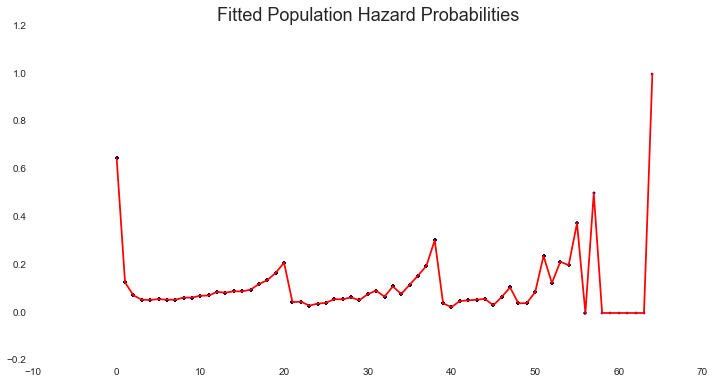

In [429]:
ppdf['predvals1'] = result.predict()
yvals = []
xvals = list(set(ppdf.PERIOD.tolist()))
for i in xvals:
    yvals.append(result.predict(exog={"PERIOD":[i]}))
f, ax = plt.subplots(1,1, figsize=(12,6))
plt.scatter(ppdf.PERIOD, ppdf.predvals1, marker=".")
plt.plot(xvals, yvals, color="r")
plt.title("Fitted Population Hazard Probabilities", fontsize="18")

## Plotting the Survival Probabilities of our Model
By iterating through the fitted hazard probabilities, we are able to calculate the population survival probabilities. This is the probability that a person who contributes to Wikipedia will continue to be editing the Wiki beyond the N month period, on average in the population.

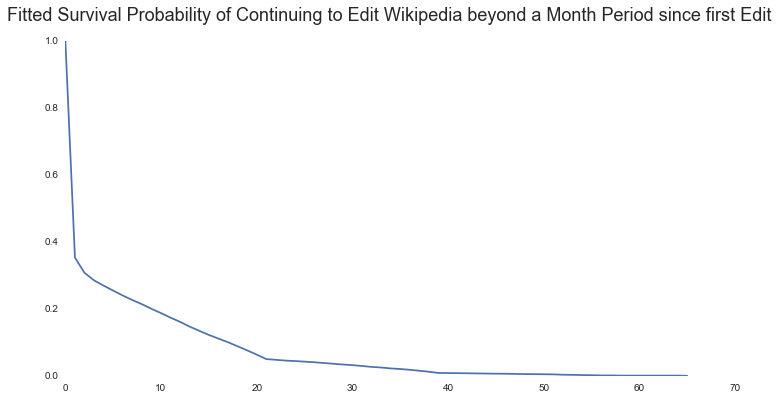

In [430]:
periods = list(set(ppdf.PERIOD.tolist()))
f, ax = plt.subplots(1,1, figsize=(12,6))

survival = 1.0
yvals = [1.0]
xvals = [0]
for p in periods:
    hazard =result.predict(exog={"PERIOD":[p]})
    survival = survival - survival*hazard
    yvals.append(survival)
    xvals.append(p+1)
line, = ax.plot(xvals, yvals)
plt.suptitle("Fitted Survival Probability of Continuing to Edit Wikipedia beyond a Month Period since first Edit" %{"p":p+1}, 
                fontsize="18")
plt.show() 

# Testing a More Parsimonious Model on Month Count
In Singer & Willett's example, they are able to fit a more parsimonious model on periods as a continuous predictor. Judging from the variation in the hazard probabilities as plotted above, I think we're going to lose a lot of fit, but let's give it a try anyway.

Since we stored predvals1 from our previous model, we will be able to compare the fitted probabilities in our more parsimonious model to the conditional probabilities per month that we got by turning each month period into a dummy variable.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  EVENT   No. Observations:               106446
Model:                            GLM   Df Residuals:                   106444
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -47273.
Date:                Sat, 04 Apr 2015   Deviance:                       94546.
Time:                        12:09:49   Pearson chi2:                 2.49e+05
No. Iterations:                     8                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.6574      0.011    -61.729      0.000        -0.678    -0.637
PERIOD        -0.1350      0.002    -80.611      0.0

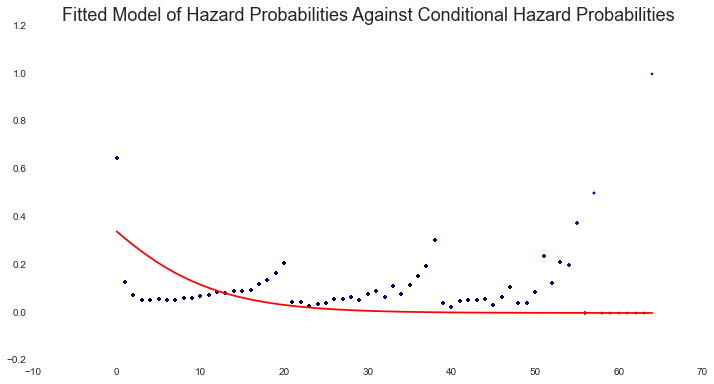

In [431]:
result = smf.glm(formula = " EVENT ~ PERIOD", 
                 data=ppdf,
                 family=sm.families.Binomial()).fit()
print result.summary()

yvals = []
xvals = list(set(ppdf.PERIOD.tolist()))
for i in xvals:
    yvals.append(result.predict(exog={"PERIOD":[i]}))
f, ax = plt.subplots(1,1, figsize=(12,6))
plt.scatter(ppdf.PERIOD, ppdf.predvals1, marker=".")
plt.plot(xvals, yvals, color="r")
plt.title("Fitted Model of Hazard Probabilities Against Conditional Hazard Probabilities", fontsize="18")

#### Although the terms are significant, the fit is dreadful. Let us not speak of this again. With more time, we might investigate the fascinating periodic spikes in hazard probabilities, which might be the result of how we constructed the data, or of some other pattern within the Wikipedia community.

# Test a relationship between  Hazard Probabilities and Reversion Rate, controlling for Month Period

We're finally testing our hypothesis, that there is a relationship between hazard probabilities and reversion rate, in the following model.

In [432]:
# GENERATE FITTED MODEL
result = smf.glm(formula = " EVENT ~ reversion_rate + C(PERIOD)", 
                 data=ppdf,
                 family=sm.families.Binomial()).fit()
print result.summary()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  EVENT   No. Observations:               106446
Model:                            GLM   Df Residuals:                   106380
Model Family:                Binomial   Df Model:                           65
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -36952.
Date:                Sat, 04 Apr 2015   Deviance:                       73904.
Time:                        12:10:20   Pearson chi2:                 1.07e+05
No. Iterations:                    23                                         
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           0.5895      0.015     40.043      0.000         0.561     0.618
C(PERIOD)[T.1]     -2.5202      0.038

#### In this logistic model of hazard probabilities, we do find a positive relationship between reversion rate and the chance of ceasing editing Wikipedia holding month periods constant, in the population of Wikipedians. Contributors with a higher lifetime reversion rate have a greater probability of ceasing editing activity than contributors with a lower revision rate (p<0.001).

# Plotting the Relationship Between Hazard Probabilities and Reversion Rate
To visually illustrate this relationship, I have picked three prototypical periods and plot the relationship betwen hazard probabilities and revision rates at those periods.

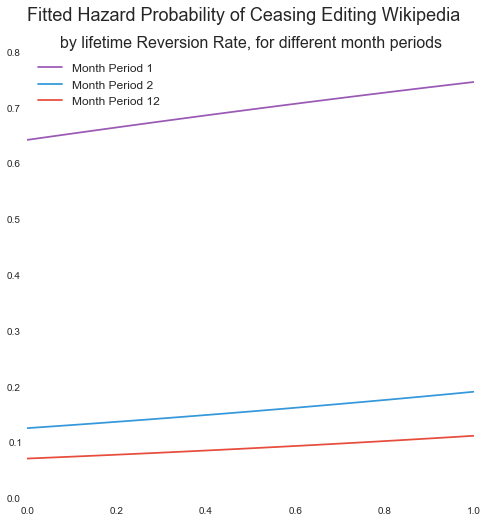

In [433]:
periods = [0,1, 11]
rates = np.linspace(0,1,100)
flatui = ["#9b59b6", "#3498db",  "#e74c3c", "#34495e", "#2ecc71"]

f, ax = plt.subplots(1,1, figsize=(8,8))

lines = []
labels = []
i=0
for p in periods:

    xvals = rates
    yvals = []
    for x in xvals:
        yvals.append(result.predict(exog={"PERIOD":[p], "reversion_rate":x}))
        
    line, = ax.plot(xvals, yvals, color=sns.color_palette(flatui)[i])
    i+=1
    lines.append(line)
    labels.append("Month Period %(n)d" % {"n":p+1})
plt.suptitle("Fitted Hazard Probability of Ceasing Editing Wikipedia" %{"p":p+1}, 
                fontsize="18")
plt.title("by lifetime Reversion Rate, for different month periods", fontsize="16")
plt.legend(lines, labels, fontsize="12", loc=2)
plt.show()


# Plotting Survival Probabilities for Prototypical Values of Reversion Rate
In this example, we pick three prototypical revision rates and plot the fitted survival probabilities at each revision rate. As you can see, editors with a higher reversion rate have lower survival probabilities by month.

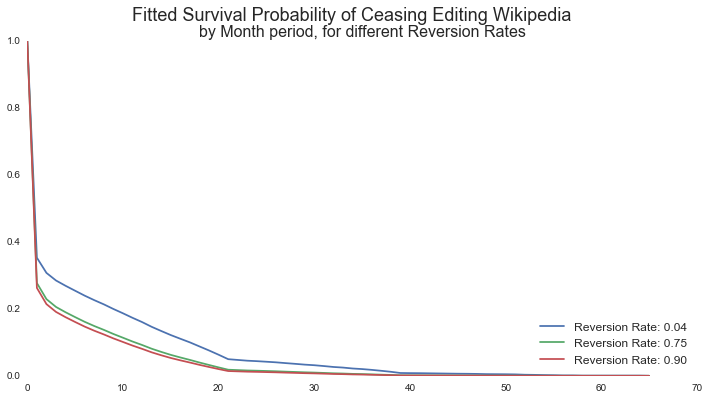

In [434]:
rates = [udf.reversion_rate.mean(), 0.75, 0.90]
periods = list(set(ppdf.PERIOD.tolist()))

f, ax = plt.subplots(1,1, figsize=(12,6))
lines = []
labels = []
for r in rates:
    survival = 1.0
    yvals = [1.0]
    xvals = [0]
    for p in periods:
        hazard =result.predict(exog={"PERIOD":[p], "reversion_rate":r})
        survival = survival - survival*hazard
        yvals.append(survival)
        xvals.append(p+1)
    line, = ax.plot(xvals, yvals)
    lines.append(line)
    labels.append("Reversion Rate: %(r).02f" % {"r":r})
plt.suptitle("Fitted Survival Probability of Ceasing Editing Wikipedia" %{"p":p+1}, 
                fontsize="18")
plt.title("by Month period, for different Reversion Rates", fontsize="16")
plt.legend(lines, labels, fontsize="12", loc=4)
plt.show() 